Создадим стриминговую сжатую модель (и заодно сохраним её в формате jit).

In [3]:
from src.configs import DistillTaskConfig, StreamingTaskConfig
from src.model import CRNN, StreamingCRNN

from tqdm.notebook import tqdm

import torch
import wandb
import torchaudio

distill_config = DistillTaskConfig(
    hidden_size=16,
    bottleneck_size=8,
    cnn_out_channels=4,
    distill_w=0.,
    attn_distill_w=0.,
    melspec_win_length=400,
    melspec_hop_length=160,
    num_epochs=100,
    use_scheduler=True,
    temperature=10
)

model = CRNN(distill_config)
_ = wandb.restore('triple-100-epochs-tiny-colab.pt', run_path="broccoliman/kws/1fhnqrzr")
model.load_state_dict(torch.load('triple-100-epochs-tiny-colab.pt', map_location=torch.device('cpu')))

model = torch.quantization.quantize_dynamic(model, dtype=torch.float16)

conf = StreamingTaskConfig()

st_model = StreamingCRNN(
    model, 
    max_window_length=conf.max_window_length,
    streaming_step_size=conf.streaming_step_size,
    share_hidden_states=conf.share_hidden_states,
    device=conf.device
)

torch.jit.save(torch.jit.script(st_model), 'kws.pt')

/usr/local/lib/python3.7/dist-packages/torch/jit/annotations.py:296: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
  warnings.warn("TorchScript will treat type annotations of Tensor "


Сделаем вавку с ключевым словом посередине.

In [4]:
noise_path_1 = 'speech_commands/_background_noise_/exercise_bike.wav'
noise_path_2 = 'speech_commands/_background_noise_/running_tap.wav'
command_path = "speech_commands/sheila/dc269564_nohash_1.wav"

noise_1 = torchaudio.load(noise_path_1)[0].squeeze()
noise_2 = torchaudio.load(noise_path_2)[0].squeeze()
command = torchaudio.load(command_path)[0].squeeze()

concat_wav = torch.cat([noise_1[-160000:], command, noise_2[160000:320000]])

Нарисуем предсказания.

  0%|          | 0/334861 [00:00<?, ?it/s]

/content/KWS/src/model.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(self.frames).unsqueeze(dim=0).to(self.device)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


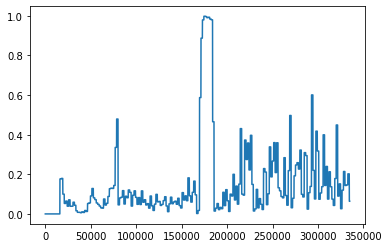

In [5]:
import seaborn as sns

predictions = []

for frame in tqdm(concat_wav):
    predictions.append(st_model(torch.tensor([frame]))[1].item())

sns.lineplot(range(len(predictions)), predictions)